# Dog-breed Classifier
---

## Contents

* [Intro](#intro)
* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dog
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Write Your Algorithm
* [Step 6](#step6): Test Your Algorithm

---

<a id='intro'></a>
## Intro

시작에 앞서, 이 노트북은 Udacity의 [Deep Learning Nanodegree](https://www.udacity.com/course/deep-learning-nanodegree--nd101)에서 공부한 내용임을 알려드립니다.

이 프로젝트의 목표는 다음과 같습니다:
* Convolutional Neural Network를 이용해 나만의 모델을 만들어 이미지를 입력받아 강아지의 품종 예측합니다.
* Transfer Learning을 이용한 강아지의 품종을 예측합니다.
* 나만의 알고리즘을 만들어 사람의 얼굴을 감지했을때 가장 닮은 품종들을 알려줍니다.

아래의 이미지는 프로젝트의 예상 결과물 중 하나입니다:

![Sample_Dog_Output](notebook_images/sample_dog_output.png)

---

<a id='step0'></a>
## Step 0: Import Datasets

__아래의 사람과 강아지 데이터셋이 반드시 필요합니다. 다운로드해주세요.__

* [강아지 데이터셋](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip)을 다운로드하시고 이 프로젝트의 홈 디렉토리에 압축을 풀어주세요.
* [사람 데이터셋](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip)도 마찬가지로 홈 디렉토리에 압축을 풀어주세요.

*참고: 윈도우즈 환경에서 다운로드 하실 경우, [7zip](http://www.7-zip.org/) 또는 [반디집](https://kr.bandisoft.com/bandizip/)을 사용하여 압축을 풀어주세요. 다른 프로그램은 사용해보지 않았습니다.

아래의 코드는, 강아지 데이터셋과 사람 데이터셋의 경로를 numpy array로 `human_files`와 `dog_files`라는 이름으로 저장하는 코드입니다.

In [7]:
import numpy as np
from glob import glob

# 강아지, 사람 데이터셋 파일의 경로들을 가져옵니다.
dog_files = np.array(glob('./dog_images/*/*/*'))
human_files = np.array(glob('./human_images/*/*'))

# 각 데이터셋의 갯수를 출력합니다.
print('전체 강아지 이미지 수: %d' % len(dog_files))
print('전체 사람 이미지 수: %d' % len(human_files))

전체 강아지 이미지 수: 8351
전체 사람 이미지 수: 13233


---

<a id='step1'></a>
## Step 1: Detect Humans

해당 섹션에서는 OpenCV를 이용하여 [Haar feature-based cascade classifier](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html)를 이용하여 사람의 얼굴을 감지할 것 입니다.

OpenCV는 [github](https://github.com/opencv/opencv/tree/master/data/haarcascades)에 XML 파일의 형태로 pre-trained된 많은 face detector를 제공합니다. 그 중 하나의 디텍터를 다운로드하여 `haardcascades` 디렉토리에 저장하였습니다. 다음의 코드는, 샘플 이미지에서 얼굴을 찾는 디텍터의 사용방법을 나타냅니다.

발견된 얼굴의 수: 1


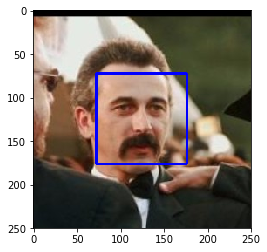

In [8]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

# Pre-trained된 Haar feature-based cascade classifier를 불러옵니다.
face_cascade = cv2.CascadeClassifier('./haarcascades/haarcascade_frontalface_alt.xml')

# 하나의 샘플 이미지를 읽어옵니다.
# OpenCV는 기본적으로 BGR형태로 이미지를 불러옵니다.
img = cv2.imread(human_files[10])

# BGR 이미지를 grayscale로 변환합니다.
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# 얼굴을 찾아냅니다.
faces = face_cascade.detectMultiScale(gray)

# 해당 이미지에서 몇개의 얼굴을 발견했는지 출력합니다.
print('발견된 얼굴의 수:', len(faces))

# 발견된 얼굴에 사각형 테두리를 그려줍니다.
for (x, y, w, h) in faces:
    cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 2)
    
# BGR 이미지를 RGB 이미지로 변환합니다.
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# 사각형 테두리가 그려진 얼굴 이미지를 보여줍니다.
plt.imshow(cv_rgb)
plt.show()

어떤 종류의 face detector를 이용하던지, 사용하기전 __이미지들을 grayscale로 변환하는 일은 필수적입니다.__ `detectMultiScale` 함수는 grayscale 이미지를 파라미터로 입력 받습니다.

위의 코드에서 `faces`는 감지된 얼굴을 numpy array의 형태로 가지고 있습니다.

###  Write a Human Face Detector 

입력된 이미지에서 감지된 사람 얼굴이 있을때 `True`를, 그렇지 않으면 `False`를 리턴하는 함수를 작성합니다. 아래는 하나의 이미지 파일 경로를 string의 형태로 입력받는 Human Face Detector입니다.

In [11]:
# img_path에 저장된 이미지에서 얼굴이 발견된다면 True를 리턴합니다.
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### Assess the Human Face Detector

__Question 1:__ 작성한 `face_detector` 함수를 테스트 해봅니다.
* `human_files`의 처음 100개의 이미지에서 사람 얼굴이 감지된 퍼센트는?
* `dog_files`의 처음 100개의 이미지에서 사람 얼굴이 감지된 퍼센트는?

__Answer:__ (코드를 작성하여 실행시켜 질문에 대한 답을 찾습니다.)

In [14]:
from tqdm import tqdm

# 각 데이터셋에서 처음 100개의 이미지를 가져옵니다.
human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

# 각 데이터셋에서 감지된 횟수를 초기화합니다.
human_detected = 0.0
dog_detected = 0.0

# 전체 파일 갯수를 가져옵니다.
num_files = len(human_files_short)

for i in range(0, num_files):
    human_path = human_files_short[i]
    dog_path = dog_files_short[i]
    
    if face_detector(human_path) == True:
        human_detected += 1
    if face_detector(dog_path) == True:
        dog_detected += 1
        
print('Haar Face Detection')
print('사람 데이터셋에서 얼굴이 감지된 확률:{: .0%}'.format(human_detected / num_files))
print('강아지 데이터셋에서 얼굴이 감지된 확률:{: .0%}'.format(dog_detected / num_files))

Haar Face Detection
사람 데이터셋에서 얼굴이 감지된 확률: 96%
강아지 데이터셋에서 얼굴이 감지된 확률: 18%


---
<a id='step2'></a>
## Step 2: Detect Dogs
해당 섹션에서는 [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html)을 이용하여 강아지를 감지해봅니다.

### Obtain Pre-trained VGG-16 Model
아래의 코드는 [ImageNet](http://www.image-net.org/)에서 미리 훈련된 weights들을 가진 VGG-16 모델을 다운로드합니다.

In [4]:
import torch
import torchvision.models as models

# VGG16 모델 불러오기
VGG16 = models.vgg16(pretrained=True)

# CUDA 사용 가능 여부 체크
use_cuda = torch.cuda.is_available()

# CUDA 사용 가능시 모델을 GPU로 옮긴다.
if use_cuda:
    VGG16 = VGG16.cuda()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to C:\Users\choonghee/.torch\models\vgg16-397923af.pth
100%|███████████████████████████████████████████████████████████████| 553433881/553433881 [07:20<00:00, 1255758.40it/s]


pre-trained된 VGG-16 모델은 ImageNet의 1000개의 카테고리로 부터 이미지가 담고있는 오브젝트에 대한 예측을 리턴해줍니다.

### Making Predictions with a Pre-trained Model

아래의 코드는 이미지에 대한 경로(예를 들어 `'./dog_images/train/001.Affenpinscher/Affenpinscher_00001.jpg'`를 파라미터로 하여 VGG-16 모델을 이용해 ImageNet의 1000개의 카테고리 중 하나를 리턴하는 함수입니다. 리턴값은 항상 0~999 입니다.

참조: pre-trainend된 모델을 가지고 Tensor를 적절히 pre-process하는 방법을 [PyTorch 문서](http://pytorch.org/docs/stable/torchvision/models.html)에서 학습해주세요.

In [8]:
from PIL import Image
import torchvision.transforms as transforms
from torch.autograd import Variable

human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

def VGG16_predict(img_path):
    '''
    이미지 경로를 입력받아 Pre-trained된 VGG-16모델을 사용하여
    알맞은 ImageNet 카테고리 중 하나를 리턴합니다.
    
    Args:
        img_path: 이미지 경로
    
    Returns:
        VGG-16 모델이 예측한 카테고리
    '''
    
    # img_path에 따른 이미지를 불러옵니다.
    img = Image.open(img_path)
    
    # VGG-16은 224x224 크기의 이미지를 입력받기 때문에 사이즈를 변환합니다.
    # PIL image를 Tensor로 변환합니다.
    # 이미지는 [0 - 1]사이의 값으로 로드되어야 하기 때문에 Normalize 해줍니다.
    data_transform = transforms.Compose([transforms.RandomResizedCrop(224),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                            std=[0.229, 0.224, 0.225])])
    
    # 위의 transformation을 적용합니다.
    img = data_transform(img)
    
    # PyTorch의 pretraind model들은 Tensor가 
    # (인풋 이미지 갯수, 컬러 채널의 수, 높이, 넓이) 차원인 것을 필요로 합니다.
    # 하지만 현재로서 (컬러 채널의 수, 높이, 넓이) 차원이기 때문에, 
    # 아래의 코드로 새로운 axis를 추가해 줍니다.
    img = img.unsqueeze(0)
    
    # PyTorch의 모델들은 Variable 형태의 입력이 필요합니다.
    # 전처리된 이미지를 Variable로 변환합니다.
    # Variable은 PyTorch Tensor의 단순 wrapper입니다.
    img = Variable(img)
    
    # 예측으로 하나의 Tensor를 (batch, 클래스에 해당하는 레이블 숫자)의 형태로 가져옵니다.
    prediction = VGG16(img)
    
    # numpy array 형태로 변환하여 maximum value를 가진 인덱스를 가져옵니다.
    prediction = prediction.data.numpy().argmax()
    
    return prediction

### Write a Dog Detector

[ImageNet의 dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a)를 보면, 강아지 품종은 key 151-264에 위치해 있습니다. 그렇기 때문에 위에서 작성한`VGG16_predict()`함수가 해당 키값들 중 하나를 리턴해 준다면, 강아지를 감지한 것이 됩니다.

아래의 `dog_detector()`함수는 이미지 경로를 입력받아 강아지가 맞다면 `True` 아니면 `False`를 리턴해줍니다.

In [10]:
### 이미지 경로를 입력받아 강아지를 찾아내면 True를 리턴합니다.
def dog_detector(img_path):
    class_index = VGG16_predict(img_path)
    
    if class_index >= 151 and class_index <= 268:
        return True
    else:
        return False

### Assess the Dog Detector

__Question 2:__ `dog_detector()`함수를 이용해 아래의 질문에 답해주세요.

* `human_files_short`의 이미지 중 탐지된 강아지의 퍼센트는?
* `dog_files_short`의 이미지 중 탐지된 강아지의 퍼센트는?

__Answer:__ (코드를 작성하여 실행시켜 질문에 대한 답을 찾습니다.)

In [11]:
# 각 데이터셋에서 감지된 횟수를 초기화합니다.
human_detected = 0.0
dog_detected = 0.0

# 전체 파일 갯수를 가져옵니다.
num_files = len(human_files_short)

for i in range(0, num_files):
    human_path = human_files_short[i]
    dog_path = dog_files_short[i]
    
    if dog_detector(human_path) == True:
        human_detected += 1
    if dog_detector(dog_path) == True:
        dog_detected += 1

print('VGG-16 Prediction')
print('사람 데이터셋에서 강아지가 감지된 확률: {0:.0%}'.format(human_detected / num_files))
print('강아지 데이터셋에서 강아지가 감지된 확률: {0:.0%}'.format(dog_detected / num_files))

VGG-16 Prediction
사람 데이터셋에서 강아지가 감지된 확률: 4%
강아지 데이터셋에서 강아지가 감지된 확률: 93%


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Step 1,2에서 이미지들로 부터 사람의 얼굴과 강아지를 감지하는 함수를 만들었습니다. 이제 이미지에서 품종을 예측하는 방법을 알아봅니다. 강아지 품종을 분류하는 하나의 CNN을 만들어 보겠습니다. 여기서는 Transfer Learning 보다는 처음부터 만들어 나가겠습니다. 목표 정확도는 적어도 10% 이상입니다. Step 4에서 Transfer Learning을 이용해 CNN을 만들어볼때, 정확도가 얼마나 향상되는지 지금 만드는 CNN과 비교해 볼 수 있을 것입니다.

이미지에서 강아지의 품종을 분류하는 작업은 굉장히 어렵다는 것을 알려드립니다. 사람의 눈으로도 Brittany와 Welsh Springer Spaniel을 구분하는 것은 전문가가 아니라면 상당히 어렵습니다.

Brittany | Welsh Springer Spaniel
- | - 
<img src="notebook_images/Brittany_02625.jpg" width="100"> | <img src="notebook_images/Welsh_springer_spaniel_08203.jpg" width="200">

최소한의 inter-class 차이(예: Curly-Coated Reriever 과 American Water Spaniels)를 나타내는 강아지 품종의 쌍들을 쉽게 찾아볼 수 있습니다.

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="notebook_images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="notebook_images/American_water_spaniel_00648.jpg" width="200">

이와 반대로, labradors는 노란색, 초콜릿색, 검은색의 품종이 있습니다. 이러한 비전 기반 알고리즘은 색깔과 상관없이 동일한 품종으로 분류하기 위해 intra-class한 차이를 극복해야합니다.

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="notebook_images/Labrador_retriever_06457.jpg" width="150"> | <img src="notebook_images/Labrador_retriever_06455.jpg" width="240"> | <img src="notebook_images/Labrador_retriever_06449.jpg" width="220">

### Specify Data Loaders for the Dog Dataset
아래의 코드에서 Training, Validation, 그리고 Test 데이터셋을 위한 세 개의 [DataLoader](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader)를 만듭니다. [커스텀 데이터셋에 관한 문서](https://pytorch.org/docs/stable/torchvision/datasets.html)를 유용한 자료로 활용하실 수 있습니다. Data Augmentation에 관심이 있으시다면, 다양한 방법의 [Transforms](https://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)를 확인해보세요!

In [2]:
# Step 3에서 필요한 라이브러리들 입니다.
# 매번 모두 실행시킬 수는 없으니까요!
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable
import torchvision.models as models
import torch.nn as nn
from PIL import Image
from PIL import ImageFile

ImageFile.LOAD_TRUNCATED_IMAGES = True
%matplotlib inline

# CUDA 사용이 가능한지 확인합니다.
use_cuda = torch.cuda.is_available()
print('CUDA 사용가능:', use_cuda)

CUDA 사용가능: False


마음대로 CNN을 구성해서 만들어 테스트를 해보다가 Accuracy 10%를 넘기는 것이 쉽지않아, 멘토의 조언대로 VGG-16 모델을 Imitating 해보기로 하였습니다. 아래의 코드는 Train, Valid, Test set에 대한 transforms를 구성한 것입니다.

In [2]:
# 일반적인 이미지 transforms
import torchvision.transforms as transforms

# Train, Valid, Test셋에 알맞는 transforms를 선언합니다.
# VGG-16 model을 imitating하기로 합니다.
# 공통적으로 Input이 224x224이므로 그에 맞게 Resize해주고, Tensor로 바꾸며
# 이미지는 [0 - 1]사이의 값으로 로드되어야 하기 때문에 Normalize 해줍니다.
transforms = {
    
    # Train transform에서는 Data Augmentation을 위해 Horizontal 방향으로 뒤집는
    # 함수를 사용하였습니다.
    'train' : transforms.Compose([transforms.Resize(256),
                                transforms.RandomResizedCrop(224),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                      std=[0.229, 0.224, 0.225])]),
    
    'valid' : transforms.Compose([transforms.Resize(256),
                                  transforms.CenterCrop(224),
                                 transforms.ToTensor(),
                                 transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                      std=[0.229, 0.224, 0.225])]),
    
    'test' : transforms.Compose([transforms.Resize(256),
                                 transforms.CenterCrop(224),
                                 transforms.ToTensor(),
                                 transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                      std=[0.229, 0.224, 0.225])])
}

위에서 작성한 transforms와 함께, 각 데이터셋에 필요한 데이터 로더들을 만듭니다.

In [3]:
# 데이터셋 구성
from torchvision import datasets
from torchvision import utils
import os

# 데이터를 로딩하기위해 사용할 subprocesses의 수입니다.
# 0은 메인 프로세스를 사용하겠다는 의미입니다.
num_workers = 0
# 한번의 batch당 얼마나 많은 샘플을 로드할 것인지 결정합니다.
batch_size = 20

# 이미지 데이터셋을 만듭니다. (Train, Valid, Test)
image_datasets = {x: datasets.ImageFolder(os.path.join('dog_images', x), transforms[x])
                 for x in ['train', 'valid', 'test']}

# 각각의 데이터 로더를 만듭니다.
data_loaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                              shuffle=True, num_workers=num_workers)
               for x in ['train', 'valid', 'test']}

아래 코드는 간단한 데이터 셋의 정보를 보여줍니다.

In [4]:
# 데이터 사이즈를 체크합니다.
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid', 'test']}

print('Training 데이터셋의 레코드 수: {}'.format(dataset_sizes['train']))
print('Validation 데이터셋의 레코드 수: {}'.format(dataset_sizes['valid']))
print('Test 데이터셋의 레코드 수: {}'.format(dataset_sizes['test']))

Training 데이터셋의 레코드 수: 6680
Validation 데이터셋의 레코드 수: 835
Test 데이터셋의 레코드 수: 836


In [5]:
# 품종 전체 레이블을 가져옵니다.
class_names = image_datasets['train'].classes
print(class_names)

['001.Affenpinscher', '002.Afghan_hound', '003.Airedale_terrier', '004.Akita', '005.Alaskan_malamute', '006.American_eskimo_dog', '007.American_foxhound', '008.American_staffordshire_terrier', '009.American_water_spaniel', '010.Anatolian_shepherd_dog', '011.Australian_cattle_dog', '012.Australian_shepherd', '013.Australian_terrier', '014.Basenji', '015.Basset_hound', '016.Beagle', '017.Bearded_collie', '018.Beauceron', '019.Bedlington_terrier', '020.Belgian_malinois', '021.Belgian_sheepdog', '022.Belgian_tervuren', '023.Bernese_mountain_dog', '024.Bichon_frise', '025.Black_and_tan_coonhound', '026.Black_russian_terrier', '027.Bloodhound', '028.Bluetick_coonhound', '029.Border_collie', '030.Border_terrier', '031.Borzoi', '032.Boston_terrier', '033.Bouvier_des_flandres', '034.Boxer', '035.Boykin_spaniel', '036.Briard', '037.Brittany', '038.Brussels_griffon', '039.Bull_terrier', '040.Bulldog', '041.Bullmastiff', '042.Cairn_terrier', '043.Canaan_dog', '044.Cane_corso', '045.Cardigan_welsh_

In [6]:
# 전체 품종의 개수를 가져옵니다.
n_classes = len(class_names)
print('전체 품종 수: {}'.format(n_classes))

전체 품종 수: 133


In [7]:
# 한개의 데이터 레코드를 보여줍니다. (input, label)의 형태입니다.
# 이미지는 Nomalized 되어 있어야하며, label은 0-132 사이의 정수입니다.
data_loaders['train'].dataset[6679]

(tensor([[[-1.3130, -1.3302, -1.3473,  ..., -0.0287, -0.0629,  0.0056],
          [-1.3130, -1.3130, -1.3302,  ...,  0.0056, -0.0116,  0.0569],
          [-1.3130, -1.3130, -1.2788,  ...,  0.0227,  0.0227,  0.0912],
          ...,
          [-0.5082, -0.5424, -0.5767,  ...,  1.0159,  0.9303,  0.5536],
          [-0.5424, -0.5424, -0.5767,  ...,  1.1187,  1.2899,  1.1187],
          [-0.4911, -0.5938, -0.6109,  ...,  0.8618,  1.4098,  1.4612]],
 
         [[-1.4055, -1.3880, -1.3880,  ...,  0.2577,  0.2402,  0.2752],
          [-1.3704, -1.3704, -1.3880,  ...,  0.2577,  0.2577,  0.3102],
          [-1.3880, -1.3704, -1.3354,  ...,  0.2402,  0.2752,  0.3627],
          ...,
          [-1.0028, -1.0378, -1.0728,  ...,  1.0455,  0.9230,  0.5203],
          [-0.9853, -1.0028, -1.0028,  ...,  1.1506,  1.3606,  1.1856],
          [-0.9153, -0.9853, -0.9678,  ...,  0.8354,  1.4657,  1.5882]],
 
         [[-1.3339, -1.3339, -1.3513,  ...,  0.3219,  0.3045,  0.3393],
          [-1.3164, -1.3339,

### Visualize Image Transformation
원하는대로 Transformation이 되었는지 확인하기 위해 이미지 샘플들을 시각화해봅니다.

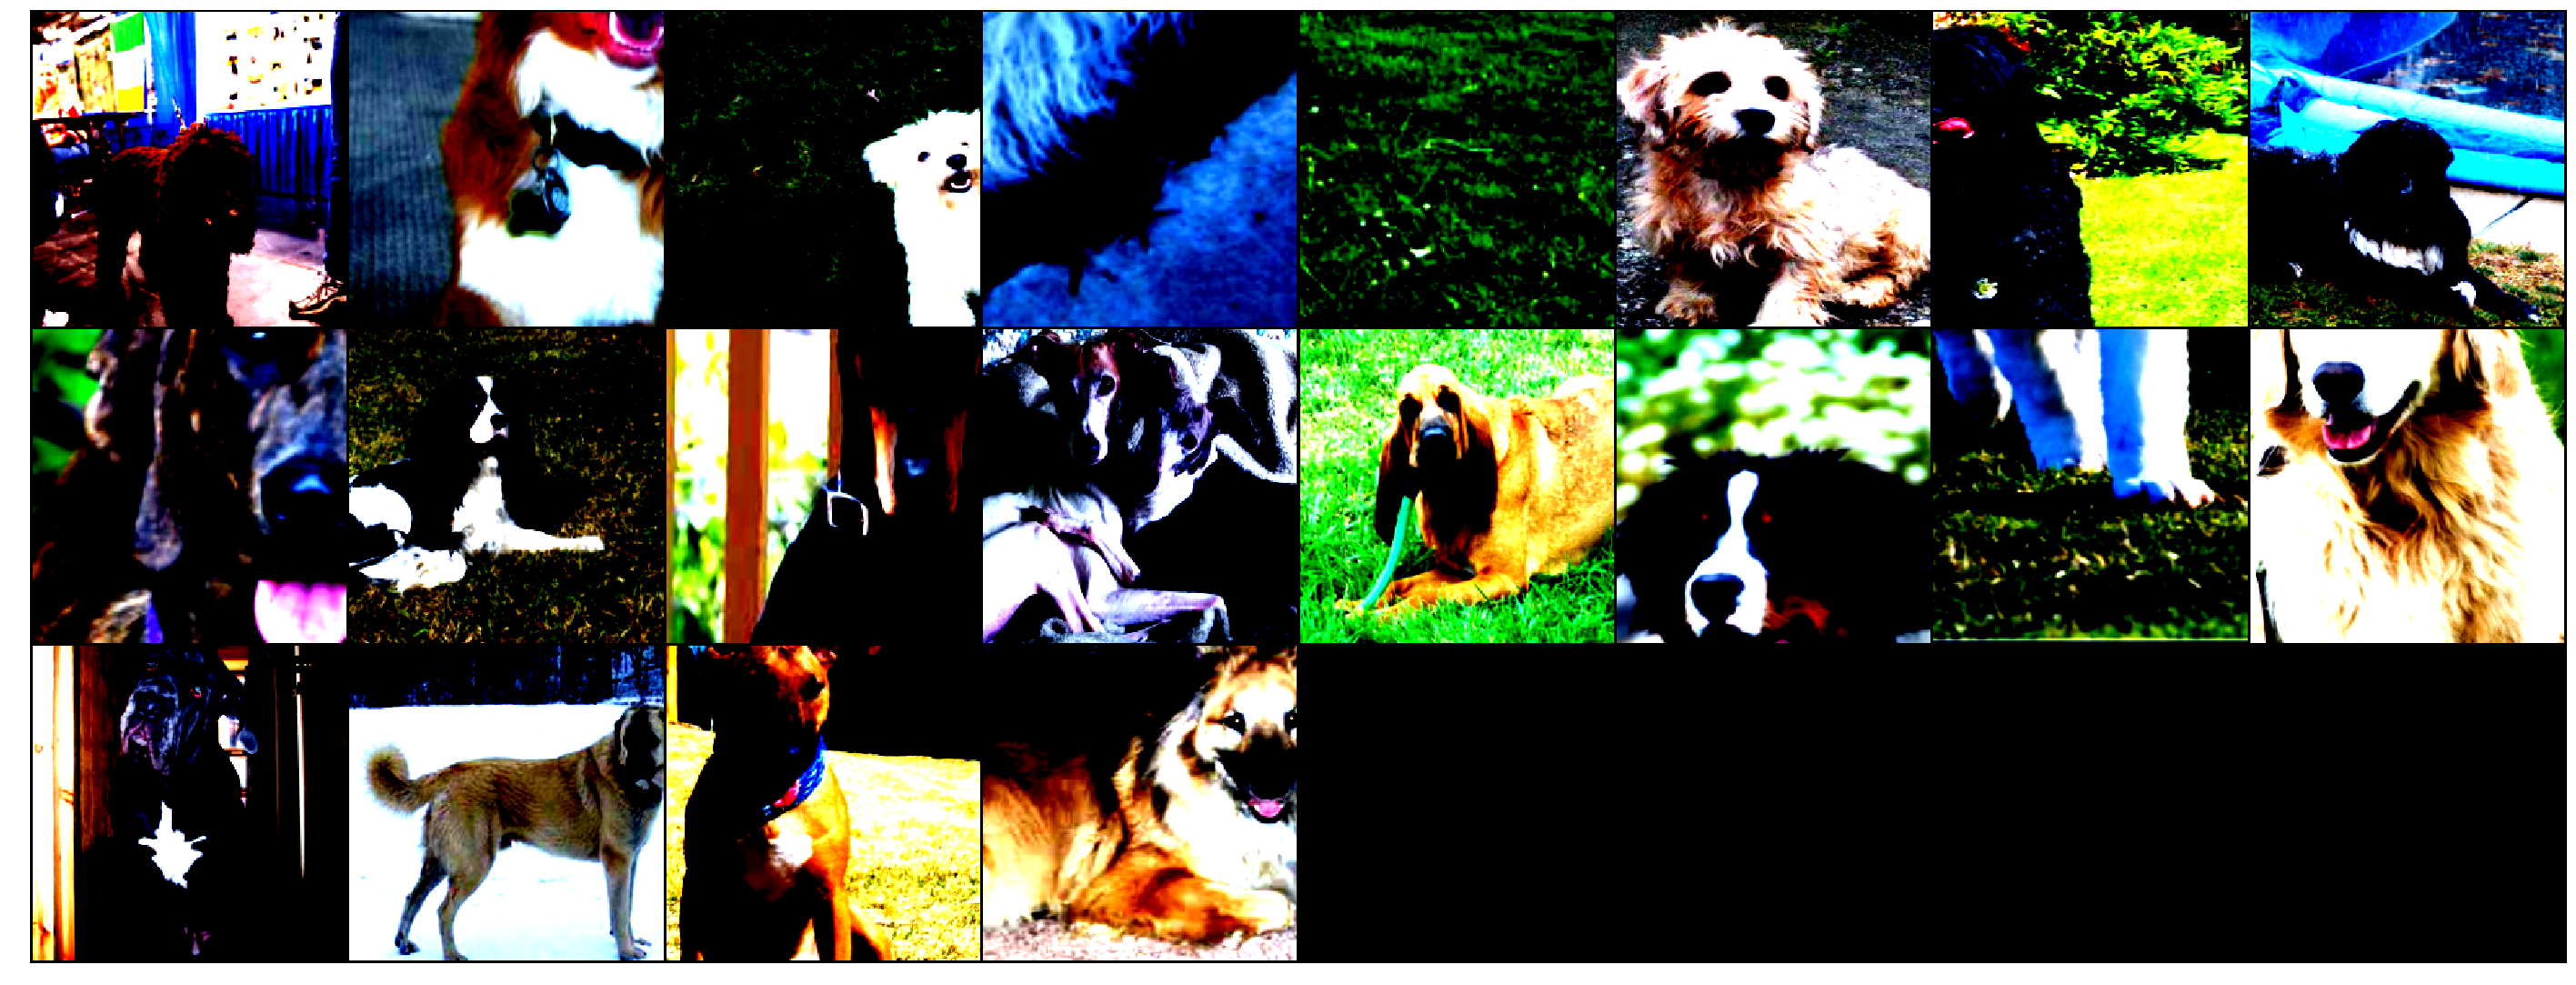

In [8]:
# 뭔가 subplots으로 해보고싶은데 ^^;;; 
def visualize_sample_images(inp):
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    
    fig = plt.figure(figsize=(50, 25))
    plt.axis('off')
    plt.imshow(inp)
    plt.pause(0.001)
    
# Training 데이터의 batch 하나를 가져옵니다.    
inputs, classes = next(iter(data_loaders['train']))

# batch를 grid로 바꿔줍니다.
grid = utils.make_grid(inputs)

# 보여주기!
visualize_sample_images(grid)

__Question 3:__ 선택하신 데이터 preprocessing에 대해 대답해주세요.
* 어떻게 resize하셨나요? 입력 Tensor로 어떤 사이즈를 선택하셨나요?
* Data Augmentation을 사용하셨나요? 사용했다면 무엇을 사용했나요?

__Answer:__ 
* `transforms.resize()` 함수를 이용하여 VGG-16의 input size와 동일하게 `224x224`로 바꾸었습니다. 이미지들의 본래 사이즈를 사용한다면, 계산에 너무 많은 시간을 소요하게되고, 컴퓨터 리소스가 모자랄 것으로 생각했습니다.
* 강아지 품종별 사진에 대한 데이터를 모으는 것이 힘들고, 이미지 속 강아지의 Rotation 이나 Translation에 따라 예측한 결과가 달라지는 것을 원하지 않았으므로 `RandomFlipHorizontal()` 함수를 통해 Data Augmentation을 실행하였습니다.

### Model Architecture
강아지 품종 분류를 위한 CNN을 만들어봅니다. 여기서는 VGG-16을 Imitating 해보도록 하겠습니다.

아래는 VGG-16의 Architecture 이미지입니다.

<img src="notebook_images/vgg16_architecture.png">

In [9]:
# PyTorch Neural Network 사용
import torch.nn as nn

# 나만의 Neural Network를 만들때 torch.nn.Module 클래스를 반드시 상속받아야합니다.
# Module 클래스는 모든 neural network의 Base 클래스 입니다.
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        ## VGG16의 아키텍쳐를 따릅니다.
        # Size 224
        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        # Size 112
        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        # Size 56
        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        # Size 28
        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv4_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        # Size 14
        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        
        # Batch Normalization은 Artificial Neural Network의 성능과 안정성을
        # 증가시키는 기법입니다.
        # 하나의 Neural Network의 어떤 레이어에게라도 zero mean/unit variance를
        # 입력으로 제공합니다.
        # 입력 레이어를 Activation을 조정하고 스케일링하는 방식으로 Normalize합니다.
        self.batch_norm64 = nn.BatchNorm2d(64)
        self.batch_norm128 = nn.BatchNorm2d(128)
        self.batch_norm256 = nn.BatchNorm2d(256)
        self.batch_norm512 = nn.BatchNorm2d(512)
        
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout()
        
        # Size 7
        self.fc1 = nn.Linear(512 * 7 * 7, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        # 마지막 Fully Connected 레이어는 강아지 품종 수 인 133입니다.
        self.fc3 = nn.Linear(4096, 133)
    
    # Feedforward를 시키는 함수입니다.
    def forward(self, x):
        x = self.relu(self.batch_norm64(self.conv1_1(x)))
        x = self.relu(self.batch_norm64(self.conv1_2(x)))
        x = self.max_pool(x)
        
        x = self.relu(self.batch_norm128(self.conv2_1(x)))
        x = self.relu(self.batch_norm128(self.conv2_2(x)))
        x = self.max_pool(x)
        
        x = self.relu(self.batch_norm256(self.conv3_1(x)))
        x = self.relu(self.batch_norm256(self.conv3_2(x)))
        x = self.relu(self.batch_norm256(self.conv3_3(x)))
        x = self.max_pool(x)
        
        x = self.relu(self.batch_norm512(self.conv4_1(x)))
        x = self.relu(self.batch_norm512(self.conv4_2(x)))
        x = self.relu(self.batch_norm512(self.conv4_3(x)))
        x = self.max_pool(x)
        
        x = self.relu(self.batch_norm512(self.conv5_1(x)))
        x = self.relu(self.batch_norm512(self.conv5_2(x)))
        x = self.relu(self.batch_norm512(self.conv5_3(x)))
        x = self.max_pool(x)
        
        # self tensor와 같은 데이터이지만 다른 크기를 가진 새로운 텐서를 반환합니다. 
        # 사이즈 -1은 다른 차원으로부터 추론을 해서 알아서 정해달라는 내용입니다.
        x = x.view(x.size(0), -1)
        
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.dropout(self.relu(self.fc2(x)))
        x = self.fc3(x)
        return x
    
# CNN 객체 생성!
model_scratch = Net()

# CUDA 사용이 가능하다면, Tensor를 GPU로 옮깁니다.
if use_cuda:
    model_scratch.cuda()

__Question 4:__ CNN 아키텍쳐의 개요와 각 단계별 이유를 알려주세요.

__Answer__: 먼저, 혼자서 10%의 정확도를 넘기는 것에 여러번 실패하여, 멘토의 조언대로 VGG16 model을 사용하기로 하였습니다.

개요:

* 입력: 224x224 RGB 이미지, 고정된 사이즈
* 커널 사이즈: 3x3, 좌/우, 상/하, 중앙으로부터 이미지의 특성을 분석하기위한 가장 작은 크기
* 패딩 크기: 1. 3x3 커널에서 Spatial Resolution을 유지하기 위함
* MaxPooling: 2x2, stride=2, 이미지의 사이즈와, 파라미터의 양을 반으로 줄이고 특성을 캡쳐하기 유용한 픽셀들을 남기기 위해 사용(계산이 줄어듦)
* Activation Function: ReLU
* Convolution Layers는 위의 코드를 참조해주세요.
* Fully Connected Layers: Dropout을 적용한 두 개의 4096개의 유닛 레이어, Dropout을 적용하지 않고 강아지 품종을 나타내는 133개의 유닛 레이어

### Specify Loss Function and Optimizer
다음 아래의 코드는 [Loss Function](http://pytorch.org/docs/stable/nn.html#loss-functions)과 [Optimizer](http://pytorch.org/docs/stable/optim.html)를 명시합니다.
여기서는 `CrossEntropyLoss()`와 `SGD()`를 각각 사용하였습니다.

In [10]:
import torch.optim as optim

# Loss Function
criterion_scratch = nn.CrossEntropyLoss()
# Optimizer
optimizer_scratch = optim.SGD(model_scratch.parameters(), lr=0.001, momentum=0.9)

 ### Train and Validate the Model
Train과 Validate를 아래의 코드에서 진행합니다. `'model_scratch.pt'`라는 이름의 파일로 모델의 최고의 파라미터를 저장합니다.

In [14]:
def train(n_epochs, train_loader, valid_loader,
          model, optimizer, criterion, use_cuda, save_path):
    """ trained된 모델을 리턴해줍니다. """
    # 가장 작은 validation loss를 기록하기 위한 변수를 초기화합니다.
    valid_loss_min = np.Inf
    
    for epoch in range(1, n_epochs+1):
        # training과 validation loss를 추적하기 위한 변수를 초기화합니다.
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        for batch_idx, (data, target) in enumerate(train_loader):
            # CUDA 사용 가능시 GPU로 옮김
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            
            # optimizer에 있는 기존의 gradient 모두를 클리어합니다.
            optimizer.zero_grad()
            # forward pass
            output = model(data)
            # loss를 구합니다.
            loss = criterion(output, target)
            # backward pass
            loss.backward()
            # 파라미터들을 업데이트합니다.
            optimizer.step()
            # training loss값을 업데이트합니다.
            train_loss += loss.item() * data.size(0)
            
        ######################
        # validate the model #
        ######################
        for batch_idx, (data, target) in enumerate(valid_loader):
            # GPU 사용
            if use_cuda:
                data, target = data.cuda(), target.cuda()
                
            # forward pass
            output = model(data)
            # loss를 구합니다.
            loss = criterion(output, target)
            # validation loss값을 업데이트 합니다.
            valid_loss += loss.item() * data.size(0)
        
        # 평균 loss를 구합니다.
        train_loss = train_loss / len(train_loader.dataset)
        valid_loss = valid_loss / len(valid_loader.dataset)
        
        # training과 validation loss를 출력합니다.
        print('Epoch: {}\tTraining Loss: {:.6f}\t Validation Loss: {:.6f}'.
             format(epoch, train_loss, valid_loss))
        
        # Validation loss가 줄어들 때 마다 모델을 저장합니다. (Early Stopping 느낌?)
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).    Saving model...'.
                 format(valid_loss_min, valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
    
    # training된 모델을 리턴합니다.
    return model

In [ ]:
n_epochs = 30
# 모델을 트레이닝 시킵니다.
model_scratch = train(n_epochs, data_loaders['train'], data_loaders['valid'], model_scratch,
                     optimizer_scratch, criterion_scratch, use_cuda, 'model_scratch.pt')
# 최고의 validation accuracy를 가진 모델을 로드합니다.
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

### Test the Model
강아지 이미지의 테스트 데이터셋을 학습시킨 모델에 적용시켜봅니다. 아래의 코드는 test loss와 accuracy를 계산해줍니다. 10% 이상의 test accuracy를 가지는게 목표입니다!

In [15]:
def test(test_loader, model, criterion, use_cuda):
    # Test loss 와 Accuracy를 기록하기 위한 변수를 초기화합니다.
    test_loss = 0.
    correct = 0.
    total = 0.
    
    for batch_idx, (data, target) in enumerate(loaders):
        # GPU를 사용합니다.
        if use_cuda:
            data, target = data.cuda(), target.cuda()
            
        # forward pass
        output = model(data)
        # loss 계산
        loss = criterion(output, target)
        # 평균 test loss를 계산합니다.
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # output으로 나온 확률을 class로 바꿉니다.
        pred = output.data.max(1, keepdim=True)[1]
        # 실제 레이블과 예측이 일치하는지 비교해봅니다.
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpu())
        total += data.size(0)
        
    print('Test Loss: {:.6f}\n'.format(test_loss))
    
    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (100. * correct / total, correct, total))

In [ ]:
# 테스트를 실행해봅니다.
test(data_loaders['test'], model_scratch, criterion_scratch, use_cuda)

---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)
Transfer Learning을 이용하여 CNN을 만들고 이미지들로 부터 강아지의 품종을 식별해봅니다. 여기서 만든 CNN은 테스트셋에 대해 최소 60% 이상의 정확도를 보여야합니다. 이곳에서는 VGG16 모델을 사용합니다.

### Specify Data Loaders for the Dog Dataset
강아지 이미지들에 대한 Training, Validation, Test 데이터셋을 위한 DataLoader를 생성합니다. (Step3에서 사용했던 `data_loaders`를 그대로 사용합니다.)

### Model Architecture
Transfer Learning을 위한 pre-trained된 VGG16 모델을 불러옵니다. 그 후, 품종 구분을 위한 133개의 output을 가진 fully connected layer를 하나 생성하여, VGG16의 마지막 레이어와 교체해줍니다.
<br /><br />

아래의 코드는 대략 다음과 같은 과정을 보여줍니다:
1. VGG16의 마지막 레이어를 새로운 데이터셋(강아지이미지와 품종 레이블)의 클래스 수와 일치하는 새로운 Fully Connected Layer와 교체합니다.
2. 새로운 Fully Connected Layer의 weights를 랜덤하게 초기화합니다.
3. VGG16의 트레이닝된 weights들은 그대로 둡니다.
4. 새로운 Fully Connected Layer에 대해서 weights를 업데이트 하기위해 트레이닝을 시작합니다.

In [3]:
import torchvision.models as models
import torch.nn as nn

# Pre-trained된 VGG16 모델을 불러옵니다.
model_transfer = models.vgg16(pretrained=True)

# VGG16의 weights를 업데이트 하지 못하도록 합니다.
for param in model_transfer.features.parameters():
    param.required_grad = False
    
# VGG16 마지막 레이어의 input 수를 가져옵니다.
n_inputs = model_transfer.classifier[6].in_features

# 새로운 Linear Layer를 만듭니다.(n_inputs -> 133)
# 새로운 레이어는 requires_grad = True를 자동적으로 가지게됩니다.
last_layer = nn.Linear(n_inputs, 133)

# VGG16의 마지막 레이어를 교체해줍니다.
model_transfer.classifier[6] = last_layer

# 레이어가 잘 바뀌었는지 출력해봅니다.
print(model_transfer)

if use_cuda:
    model_transfer = model_transfer.cuda()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

__Question 5:__ 최종 CNN 아키텍처를 위해 했던 과정을 대략적으로 설명해주세요. 우리의 목표와 해당 아키텍처가 잘 맞는다고 생각한 이유를 말해주세요.

__Answer:__ Step 3에서 VGG16을 Imitating 해보았지만, 본래의 VGG16과의 성능 차이가 얼마나 있을지 궁금했습니다. 제한된 컴퓨터 리소스와, 데이터셋의 크기, 그리고 트레이닝을 위한 시간을 가진 저로서는 pre-trained된 VGG16이 테스트셋에 대하여 어떤 정확도를 보여줄지 궁금했습니다.

VGG16이 현재 목표와 알맞는 모델이라고 생각합니다. VGG16은 이미 거대한 데이터셋을 훈련하였기 때문에, 제가 새로만든 레이어만 잘 훈련시키면 된다고 생각하였습니다. Overfitting은 이미 거대한 데이터셋을 훈련하였기 때문에 문제가 되지 않을것이라 생각하였습니다.
<br />

### Specify Loss Function and Optimizer
다음 아래의 코드는 [Loss Function](http://pytorch.org/docs/stable/nn.html#loss-functions)과 [Optimizer](http://pytorch.org/docs/stable/optim.html)를 명시합니다.
여기서는 `CrossEntropyLoss()`와 `SGD()`를 각각 사용하였습니다.

In [6]:
import torch.optim as optim

criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.SGD(model_transfer.classifier.parameters(), lr=0.001)

### Train and Validate the Model
Train과 Validate를 아래의 코드에서 진행합니다. `'model_transfer.pt'`라는 이름의 파일로 모델의 최고의 파라미터를 저장합니다.

In [ ]:
n_epochs = 20
model_transfer = train(n_epochs, data_loaders['train'], data_loaders['valid'], model_transfer,
                     optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')

# 최고의 validation accuracy를 가진 모델을 로드합니다.
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

### Test the Model
강아지 이미지의 테스트 데이터셋을 학습시킨 모델에 적용시켜봅니다. 아래의 코드는 test loss와 accuracy를 계산해줍니다. 60% 이상의 test accuracy를 가지는게 목표입니다!

In [ ]:
test(data_loaders['test'], model_transfer, criterion_transfer, use_cuda)

### Predict Dog Breed with the Model
이미지 경로를 입력받아 앞서 만든 모델로 예측한 강아지 품종(`Affenpinscher`, `Afghan hound`, etc)을 리턴해주는 함수를 만듭니다.

In [7]:
# GPU 또는 CPU를 디바이스로 설정해줍니다.
device = torch.device("cuda:0" if use_cuda else "cpu")

In [14]:
def predict_breed_transfer(img_path):
    # class names without number (Affenpinscher, Brussels griffon...)
    # class names with number (001.Affenpinscher', '038.Brussels_griffon')
    class_names_without_number = [item[4:].replace("_", " ") for item in image_datasets['train'].classes]
    class_names_with_number = image_datasets['train'].classes
    
    # 이미지를 로드합니다.
    img = Image.open(img_path)
    
    # 이미지 전처리 ^^
    transform_predict = transforms.Compose([transforms.Resize(256),
                                           transforms.CenterCrop(224),
                                           transforms.ToTensor(),
                                           transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                 std=[0.229, 0.224, 0.225])])
    # 전처리를 적용시키고, 이미지 Tensor를 얻습니다.
    img_tensor = transform_predict(img)
    
    # 아래의 코드가 없을시 다음과 같은 에러가 발생합니다.
    # RuntimeError: expected stride to be a single integer value or a list of 1 values 
    # to match the convolution dimensions, but got stride=[1, 1]
    img_tensor = img_tensor.unsqueeze_(0)
    
    # 사용할 디바이스로 보내줍니다.
    img_tensor = img_tensor.to(device)
    
    # PyTorch의 모델들은 Variable 형태의 입력이 필요합니다.
    # 전처리된 이미지를 Variable로 변환합니다.
    # Variable은 PyTorch Tensor의 단순 wrapper입니다.
    img_var = Variable(img_tensor)
    
    # 앞서 만든 모델로 output를 받아냅니다.
    output = model_transfer(img_var)
    
    # Softmax: 입력받은 값을 출력으로 0~1 사이의 값으로 모두 정규화하며
    #          출력 값들의 총합은 항상 1이되는 특성을 가진 함수이다.
    # 어떤 품종의 확률이 높은지 가려냅니다.
    softmax = nn.Softmax(dim=1)
    preds = softmax(output)
    
    # 가장 높은 확률을 가진 세 개의 품종을 가져옵니다.
    top_preds = torch.topk(preds, 3)
    
    # 레이블 출력용 입니다. 세 개의 품종의 이름을 가져옵니다.
    labels_without_number = [class_names_without_number[i] for i in top_preds[1][0]]
    labels_with_number = [class_names_with_number[i] for i in top_preds[1][0]]
    
    # 확률을 Tensor 타입으로 가져옵니다.
    probs = top_probs[0][0]
    
    return labels_without_number, labels_with_number, probs

<a id='step5'></a>
## Step 5: Write Your Algorithm
이미지의 파일 경로를 입력받아 사람인지 강아지인지 아니면 둘다 아닌지 결정하는 알고리즘을 만들어봅니다.

* 만약 강아지이라면, 예상되는 품종들을 리턴해줍니다.
* 만약 사람이라면, 닮은 품종들을 리턴해줍니다.
* 만약 둘다 아니라면, 에러 메세지를 출력해줍니다.

Step 1과 2에서 작성한 `face_detector`와 `human_detector`함수를 사용합니다. 강아지 품종을 예측하기 위해서 Step 4에서 Transfer Learning을 이용해 작성한 CNN은 **반드시 사용하도록합니다.**

아래는 예상되는 결과물의 이미지입니다:

![Sample Human Output](notebook_images/sample_human_output.png)

### Write Your Algorithm

In [9]:
import glob

# 테스트 이미지들을 가져옵니다.
human_files = glob.glob('./test_images/human_images/*')
dog_files = glob.glob('./test_images/dog_images/*')

In [10]:
# 이미지를 보여주는 함수 입니다.
def display_image(img_path):
    # Display image
    img = Image.open(img_path)
    _, ax = plt.subplots()
    ax.imshow(img)
    plt.axis('off')
    plt.show()
    
# 강아지 품종 이미지를 보여주는 함수 입니다.
def display_breeds(labels):
    fig = plt.figure(figsize=(16,4))
    for i, label in enumerate(labels):
        subdir = ''.join(['dog_images/valid/', label + '/'])
        file = random.choice(os.listdir(subdir))
        path = ''.join([subdir, file])
        img = Image.open(path)
        ax = fig.add_subplot(1,3,i+1)
        ax.imshow(img, cmap="gray", interpolation='nearest')
        plt.title(label.split('.')[1])
        plt.axis('off')
    plt.show()

In [12]:
import random

def run_app(img_path):
    # 예상되는 품종과 확률을 가져옵니다.
    labels_without_number, labels_with_number, probs = predict_breed_transfer(img_path)
    
    # 강아지인 경우
    if probs[0] > 0.3:
        # 이미지를 보여줍니다.
        print("강아지네요!")
        display_image(image_path)
        
        # 예상되는 품종과 확률을 출력합니다.
        print("예측한 품종과 확률:\n")
        sentence = ""
        for pred_label, prob in zip(labels_without_number, probs):
            print(pred_label)
            print('{:.2f}%'.format(100*prob))
        print('\n')
        
        # 예상되는 품종들의 이미지를 출력합니다.
        display_breeds(labels_with_number)
    
    # 사람인 경우
    elif face_detector(img_path):
        # 이미지를 보여줍니다.
        print("사람이네요!")
        display_image(img_path)
        
        # 가장 닮은 품종을 보여줍니다.
        print("가장 닮은 품종:\n")
        for pred_label, prob in zip(labels_without_number, probs):
            print(pred_label)
        print('\n')
        
        # 닮은 품종들의 이미지를 출력합니다.
        display_breeds(labels_with_number)
    
    # 둘다 아닌경우
    else:
        # 이미지만 출력합니다.
        print("사람인지 강아지인지 구분할 수가 없네요!")
        display_image(img_path)
        print('\n')
        
    print('\n')

<a id='step6'></a>
## Step 6: Write Your Algorithm
해당 섹션에서는 Step 5에서 작성한 알고리즘을 테스트해봅니다. 사람이라면 어떤 품종을 닮았을지, 강아지라면 정확하게 품종을 예측해내는지, 실수로 고양이 이미지가 섞여있다면 어떻게 할 것인지 확인해봅시다!

## Test Your Algorithm on Sample Images!
최소 6개 이상의 이미지를 가지고 테스트를 합니다. 최소 2개의 사람 이미지와 2개의 강아지 이미지를 사용하도록 합니다.

__Question 6:__ 예상한대로 결과물이 잘 나왔나요? 아니면 기대에 미치지 못했나요? 최소 세 개 이상의 개선점을 적어주세요.

__Answer:__
1. 축구선수 캉테의 이미지를 입력하였더니 강아지로 분류를 하였습니다. 사람과 강아지를 구분짓는 threshold를 조정할 필요가 있겠습니다.
2. 같은 코드가 반복됨으로 함수로 따로 작성하여 모듈화할 필요가 있겠습니다. (완료!)
33. run_app()함수가 모델을 입력받을 수 있도록하여 모델별 성능을 비교해 볼 수 있도록 하는게 좋겠습니다.

In [15]:
# 테스트!
for file in np.hstack((human_files[:3], dog_files[:3])):
    run_app(file)

NameError: name 'image_datasets' is not defined